In [1]:
# Long Short Cointegração

In [2]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [3]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [5]:

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 1, 1)

tickers = ['CYRE3.SA', 'JHSF3.SA', 'MRVE3.SA', 'GFSA3.SA', 'HBOR3.SA', 'EVEN3.SA']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  6 of 6 completed


,CYRE3.SA,EVEN3.SA,GFSA3.SA,HBOR3.SA,JHSF3.SA,MRVE3.SA
Date,,,,,,
2019-12-20,29.180000,14.68,7.51,21.40,6.76,20.950001
2019-12-23,29.250000,14.85,8.05,22.50,7.08,20.980000
2019-12-26,30.000000,15.26,8.43,22.10,7.24,21.530001
2019-12-27,30.020000,15.32,8.58,22.50,7.06,21.940001
2019-12-30,29.690001,15.56,8.67,22.75,7.13,21.549999


[('GFSA3.SA', 'MRVE3.SA'), ('HBOR3.SA', 'JHSF3.SA')]


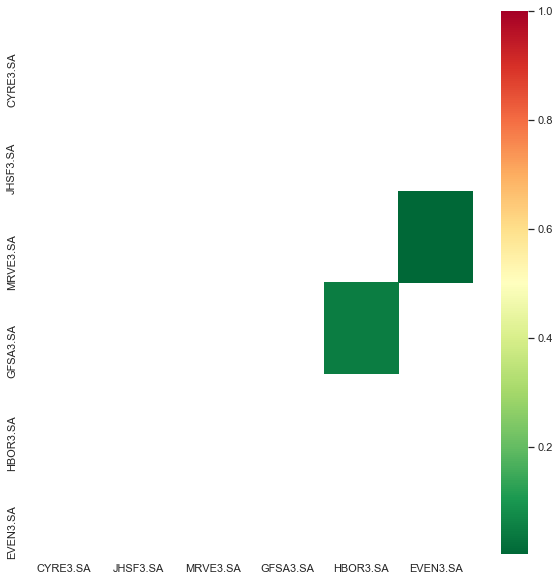

In [6]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [7]:
S1 = df['GFSA3.SA']
S2 = df['MRVE3.SA']

score, pvalue, _ = coint(S1, S2)
pvalue

0.0030821911923270117

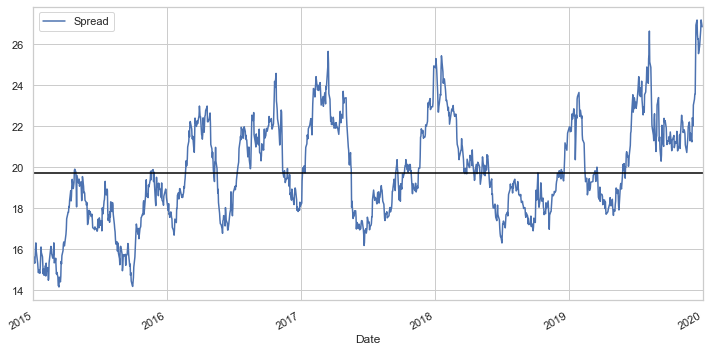

In [8]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['GFSA3.SA']
b = results.params['GFSA3.SA']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2015-01-01', '2020-01-01')
plt.legend(['Spread']);

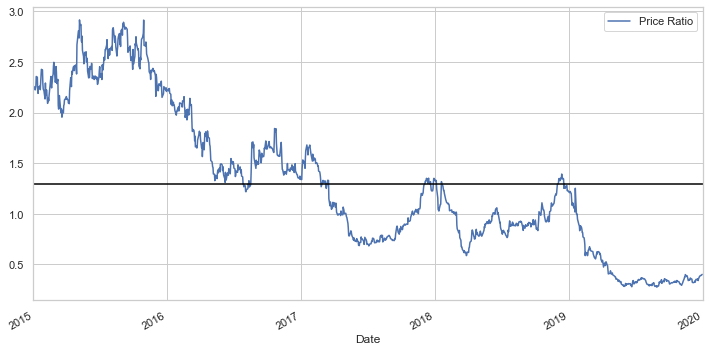

In [9]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2015-01-01', '2020-01-01')
plt.legend(['Price Ratio']);

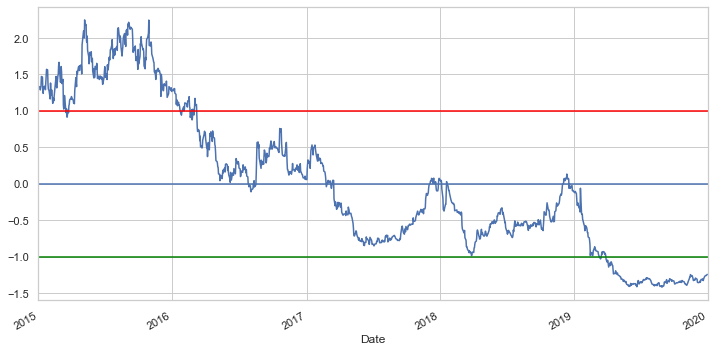

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2015-01-01', '2020-01-01')
plt.show()

In [11]:
ratios = df['GFSA3.SA'] / df['MRVE3.SA'] 
print(len(ratios) * .70 )

868.6999999999999


In [12]:
train = ratios[:881]
test = ratios[881:]

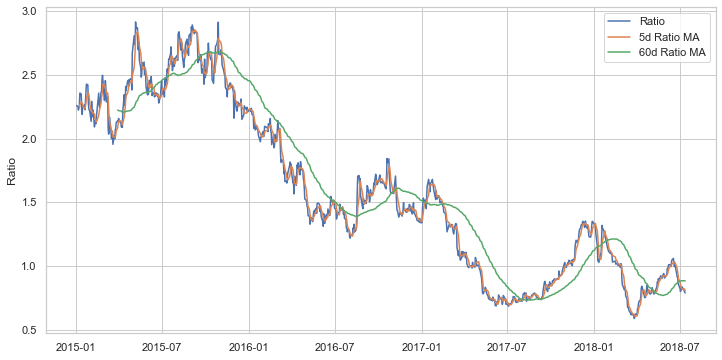

In [13]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

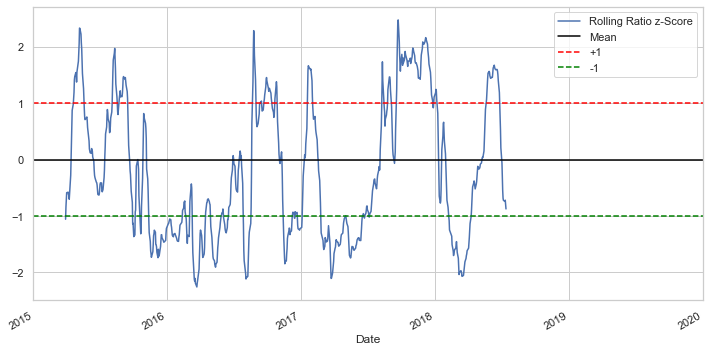

In [14]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2015-01-01', '2020-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()